In [1]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
from stable_baselines3 import DQN
from stable_baselines3 import PPO
from sb3_contrib import TRPO
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from stable_baselines3.common.monitor import Monitor

In [2]:
np.random.seed(42)
torch.manual_seed(42)

In [3]:
class GridWorldEnv(gym.Env):
    def __init__(self, grid_size=10, blocked_cells=None, start_pos=(0, 0), target_pos=(9, 9)):
        super(GridWorldEnv, self).__init__()
        self.grid_size = grid_size
        self.start_pos = start_pos
        self.target_pos = target_pos

        # Actions: 0=Up, 1=Down, 2=Left, 3=Right
        self.action_space = spaces.Discrete(4)

        # Observations: Agent's position represented as a Box space
        self.observation_space = spaces.Box(
            low=0,
            high=self.grid_size - 1,
            shape=(2,),
            dtype=np.float32
        )

        # Initialize the grid
        self.blocked_cells = blocked_cells or []
        self.reset()

    def reset(self, *, seed=None, options=None):
        # Set the seed
        self._seed = seed
        super().reset(seed=seed)

        self.agent_pos = np.array(self.start_pos, dtype=np.float32)
        return self.agent_pos, {}

    def step(self, action):
        x, y = self.agent_pos.astype(int)
        if action == 0 and x > 0:  # Up
            x -= 1
        elif action == 1 and x < self.grid_size - 1:  # Down
            x += 1
        elif action == 2 and y > 0:  # Left
            y -= 1
        elif action == 3 and y < self.grid_size - 1:  # Right
            y += 1

        next_pos = (x, y)
        if next_pos not in self.blocked_cells:
            self.agent_pos = np.array(next_pos, dtype=np.float32)

        done = np.array_equal(self.agent_pos, np.array(self.target_pos, dtype=np.float32))
        reward = 1.0 if done else -0.01  # Encourage faster completion
        return self.agent_pos, reward, done, False, {}

    def render(self, mode='human'):
        grid = np.full((self.grid_size, self.grid_size), '.', dtype=str)
        for cell in self.blocked_cells:
            grid[cell] = '#'
        grid[self.target_pos] = 'G'  # Goal
        grid[tuple(self.agent_pos.astype(int))] = 'A'  # Agent
        print('\n'.join(' '.join(row) for row in grid))
        print()

In [4]:
blocked_cells = [
    (1, 1), (1, 2), (1, 3),
    (2, 3), (3, 3), (4, 3),
    (5, 5), (5, 6), (5, 7),
    # Add more blocked cells as desired
]

In [5]:
env = GridWorldEnv(blocked_cells=blocked_cells)

env_dqn = Monitor(GridWorldEnv(blocked_cells=blocked_cells))
env_ppo = Monitor(GridWorldEnv(blocked_cells=blocked_cells))
env_trpo = Monitor(GridWorldEnv(blocked_cells=blocked_cells))

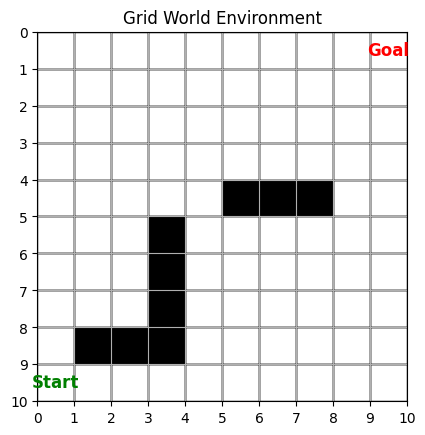

In [6]:
def visualize_environment(env):
    fig, ax = plt.subplots()
    for x in range(env.grid_size):
        for y in range(env.grid_size):
            if (x, y) in env.blocked_cells:
                ax.add_patch(patches.Rectangle((y, env.grid_size - x - 1), 1, 1, color='black'))
            else:
                ax.add_patch(patches.Rectangle((y, env.grid_size - x - 1), 1, 1, edgecolor='black', fill=False))

    # Mark the start and goal positions
    ax.text(env.start_pos[1] + 0.5, env.grid_size - env.start_pos[0] - 0.5, 'Start', ha='center', va='center', color='green', fontsize=12, fontweight='bold')
    ax.text(env.target_pos[1] + 0.5, env.grid_size - env.target_pos[0] - 0.5, 'Goal', ha='center', va='center', color='red', fontsize=12, fontweight='bold')

    ax.set_xlim(0, env.grid_size)
    ax.set_ylim(0, env.grid_size)
    ax.set_xticks(range(env.grid_size + 1))
    ax.set_yticks(range(env.grid_size + 1))
    ax.grid(True)
    ax.set_aspect('equal')
    plt.gca().invert_yaxis()
    plt.title('Grid World Environment')
    plt.show()

# Call the function
visualize_environment(env)

In [7]:
# DQN
dqn_model = DQN('MlpPolicy', env_dqn, verbose=1)
dqn_model.learn(total_timesteps=10000)

Using cuda device
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 174      |
|    ep_rew_mean      | -0.728   |
|    exploration_rate | 0.34     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 1069     |
|    time_elapsed     | 0        |
|    total_timesteps  | 695      |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00884  |
|    n_updates        | 148      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 112      |
|    ep_rew_mean      | -0.105   |
|    exploration_rate | 0.153    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 1105     |
|    time_elapsed     | 0        |
|    total_timesteps  | 892      |
| train/              |          |
|    learning_rate    | 0.0001   |
| 

In [8]:
# PPO
ppo_model = PPO('MlpPolicy', env_ppo, verbose=1)
ppo_model.learn(total_timesteps=10000)

Using cuda device
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 613      |
|    ep_rew_mean     | -5.12    |
| time/              |          |
|    fps             | 949      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 420         |
|    ep_rew_mean          | -3.19       |
| time/                   |             |
|    fps                  | 744         |
|    iterations           | 2           |
|    time_elapsed         | 5           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.010798355 |
|    clip_fraction        | 0.0816      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.38       |
|    explained_vari

In [9]:
# TRPO
trpo_model = TRPO('MlpPolicy', env_trpo, verbose=1)
trpo_model.learn(total_timesteps=10000)

Using cuda device
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 556      |
|    ep_rew_mean     | -4.54    |
| time/              |          |
|    fps             | 1011     |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                  |            |
|    ep_len_mean            | 225        |
|    ep_rew_mean            | -1.24      |
| time/                     |            |
|    fps                    | 954        |
|    iterations             | 2          |
|    time_elapsed           | 4          |
|    total_timesteps        | 4096       |
| train/                    |            |
|    explained_variance     | -0.1530037 |
|    is_line_search_success | 1          |
|    kl_divergence_loss     | 0.00752    |
|    learning_rate          | 0.001      |
|    

In [10]:
# def visualize_agent(model, env):
#     obs, _ = env.reset()
#     done = False
#     truncated = False
#     positions = [obs.copy()]

#     while not (done or truncated):
#         action, _ = model.predict(obs)
#         obs, reward, done, truncated, _ = env.step(action)
#         positions.append(obs.copy())

#     # Plot the grid
#     fig, ax = plt.subplots()
#     for x in range(env.grid_size):
#         for y in range(env.grid_size):
#             if (x, y) in env.blocked_cells:
#                 ax.add_patch(patches.Rectangle((y, env.grid_size - x - 1), 1, 1, color='black'))
#             else:
#                 ax.add_patch(patches.Rectangle((y, env.grid_size - x - 1), 1, 1, edgecolor='black', fill=False))

#     # Plot the agent's path
#     x_coords = [pos[1] + 0.5 for pos in positions]
#     y_coords = [env.grid_size - pos[0] - 0.5 for pos in positions]
#     ax.plot(x_coords, y_coords, marker='o', label='Agent Path')

#     # Mark the start and goal positions
#     ax.text(env.start_pos[1] + 0.5, env.grid_size - env.start_pos[0] - 0.5, 'Start', ha='center', va='center', color='green', fontsize=12, fontweight='bold')
#     ax.text(env.target_pos[1] + 0.5, env.grid_size - env.target_pos[0] - 0.5, 'Goal', ha='center', va='center', color='red', fontsize=12, fontweight='bold')

#     ax.set_xlim(0, env.grid_size)
#     ax.set_ylim(0, env.grid_size)
#     ax.set_xticks(range(env.grid_size + 1))
#     ax.set_yticks(range(env.grid_size + 1))
#     ax.grid(True)
#     ax.set_aspect('equal')
#     plt.gca().invert_yaxis()
#     plt.title('Agent Path Visualization')
#     ax.legend()
#     plt.show()

def visualize_agent(model, env, max_steps=500):
    obs, _ = env.reset()
    done = False
    truncated = False
    positions = [obs.copy()]
    step_count = 0

    while not (done or truncated) and step_count < max_steps:
        action, _ = model.predict(obs)
        obs, reward, done, truncated, _ = env.step(action)
        positions.append(obs.copy())
        step_count += 1

    if step_count >= max_steps:
        print(f"Agent did not reach the goal within {max_steps} steps.")
    else:
        print(f"Agent reached the goal in {step_count} steps.")

    # Plot the grid
    fig, ax = plt.subplots()
    for x in range(env.grid_size):
        for y in range(env.grid_size):
            if (x, y) in env.blocked_cells:
                ax.add_patch(patches.Rectangle((y, env.grid_size - x - 1), 1, 1, color='black'))
            else:
                ax.add_patch(patches.Rectangle((y, env.grid_size - x - 1), 1, 1, edgecolor='black', fill=False))

    # Plot the agent's path
    x_coords = [pos[1] + 0.5 for pos in positions]
    y_coords = [env.grid_size - pos[0] - 0.5 for pos in positions]
    ax.plot(x_coords, y_coords, marker='o', label='Agent Path')

    # Mark the start and goal positions
    ax.text(env.start_pos[1] + 0.5, env.grid_size - env.start_pos[0] - 0.5, 'Start', ha='center', va='center', color='green', fontsize=12, fontweight='bold')
    ax.text(env.target_pos[1] + 0.5, env.grid_size - env.target_pos[0] - 0.5, 'Goal', ha='center', va='center', color='red', fontsize=12, fontweight='bold')

    ax.set_xlim(0, env.grid_size)
    ax.set_ylim(0, env.grid_size)
    ax.set_xticks(range(env.grid_size + 1))
    ax.set_yticks(range(env.grid_size + 1))
    ax.grid(True)
    ax.set_aspect('equal')
    plt.gca().invert_yaxis()
    plt.title('Agent Path Visualization')
    ax.legend()
    plt.show()


DQN
Agent did not reach the goal within 10000 steps.


/data/smbh/.venvs/rl_2024_fall/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.grid_size to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.grid_size` for environment variables or `env.get_wrapper_attr('grid_size')` that will search the reminding wrappers.
  logger.warn(
/data/smbh/.venvs/rl_2024_fall/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.blocked_cells to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.blocked_cells` for environment variables or `env.get_wrapper_attr('blocked_cells')` that will search the reminding wrappers.
  logger.warn(
/data/smbh/.venvs/rl_2024_fall/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.start_pos to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwra

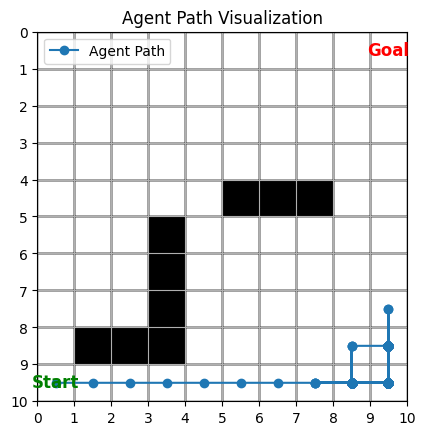

In [11]:
# Visualize DQN agent
print("DQN")
visualize_agent(dqn_model, env_dqn, 10000)

PPO
Agent reached the goal in 34 steps.


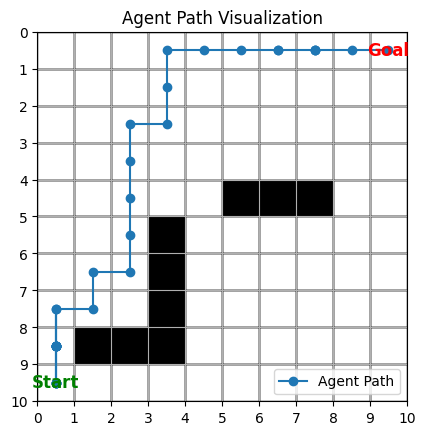

In [12]:
# Visualize PPO agent
print("PPO")
visualize_agent(ppo_model, env_ppo, 10000)

TRPO
Agent reached the goal in 39 steps.


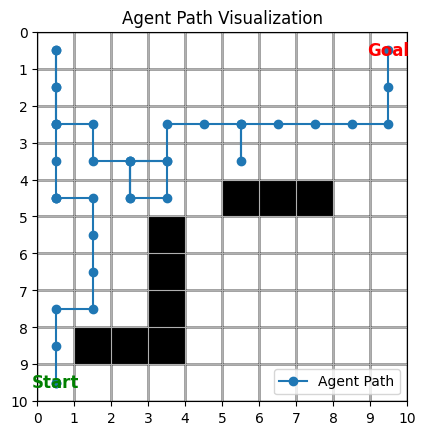

In [13]:
# Visualize TRPO agent
print("TRPO")
visualize_agent(trpo_model, env_trpo, 10000)

In [16]:
def get_agent_positions(model, env, max_steps=500):
    obs, _ = env.reset()
    done = False
    positions = [obs.copy()]
    step_count = 0
    
    while not (done) and step_count < max_steps:
        action, _ = model.predict(obs)
        obs, reward, done, truncated, _ = env.step(action)
        positions.append(obs.copy())
        step_count += 1
        if truncated:
            break

    if step_count >= max_steps:
        print(f"Agent did not reach the goal within {max_steps} steps.")
    else:
        print(f"Agent reached the goal in {step_count} steps.")

    return positions

In [17]:
# DQN data
dqn_rewards = env_dqn.get_episode_rewards()
dqn_lengths = env_dqn.get_episode_lengths()

# PPO data
ppo_rewards = env_ppo.get_episode_rewards()
ppo_lengths = env_ppo.get_episode_lengths()

# TRPO data
trpo_rewards = env_trpo.get_episode_rewards()
trpo_lengths = env_trpo.get_episode_lengths()

# Get positions
positions_dqn = get_agent_positions(dqn_model, env_dqn)
positions_ppo = get_agent_positions(ppo_model, env_ppo)
positions_trpo = get_agent_positions(trpo_model, env_trpo)

Agent did not reach the goal within 500 steps.
Agent reached the goal in 29 steps.
Agent reached the goal in 34 steps.


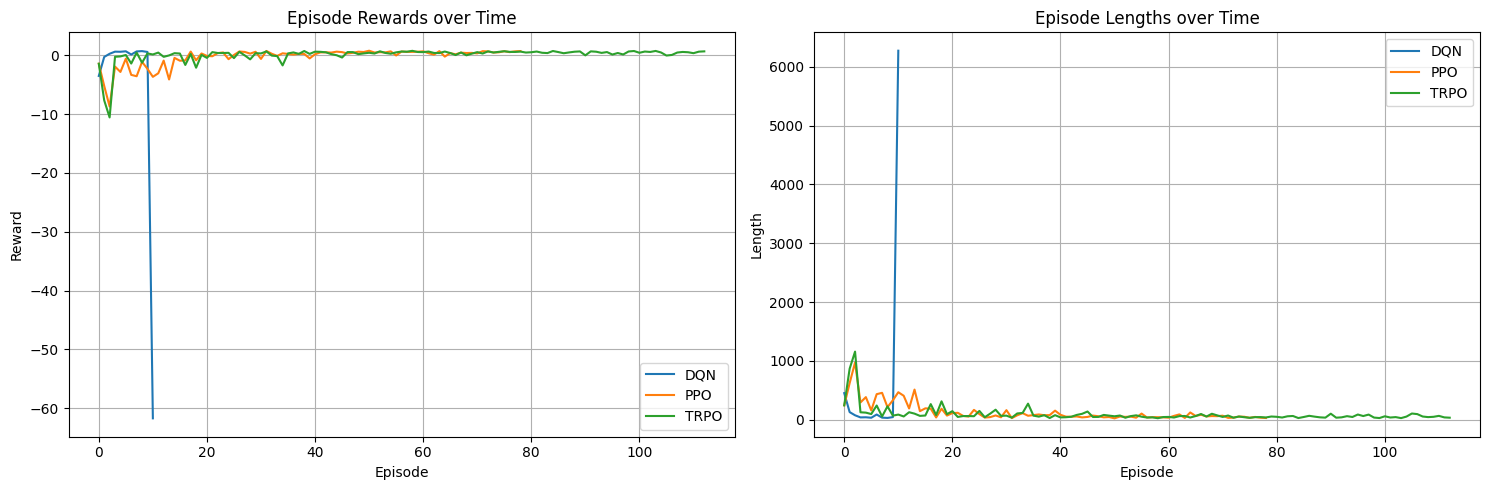

In [18]:
# Create a figure with two subplots: one for rewards, one for lengths
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Episode Rewards Plot
ax[0].plot(dqn_rewards, label='DQN')
ax[0].plot(ppo_rewards, label='PPO')
ax[0].plot(trpo_rewards, label='TRPO')
ax[0].set_title('Episode Rewards over Time')
ax[0].set_xlabel('Episode')
ax[0].set_ylabel('Reward')
ax[0].legend()
ax[0].grid(True)

# Episode Lengths Plot
ax[1].plot(dqn_lengths, label='DQN')
ax[1].plot(ppo_lengths, label='PPO')
ax[1].plot(trpo_lengths, label='TRPO')
ax[1].set_title('Episode Lengths over Time')
ax[1].set_xlabel('Episode')
ax[1].set_ylabel('Length')
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()

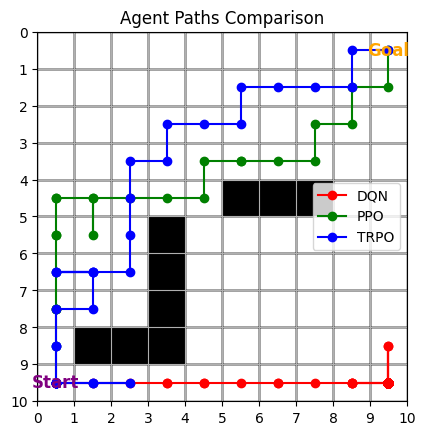

In [19]:
def plot_agent_paths(env, positions_dict):
    fig, ax = plt.subplots()
    
    # Plot the grid
    for x in range(env.grid_size):
        for y in range(env.grid_size):
            if (x, y) in env.blocked_cells:
                ax.add_patch(patches.Rectangle((y, env.grid_size - x - 1), 1, 1, color='black'))
            else:
                ax.add_patch(patches.Rectangle((y, env.grid_size - x - 1), 1, 1, edgecolor='black', fill=False))

    # Colors for each agent
    colors = {'DQN': 'red', 'PPO': 'green', 'TRPO': 'blue'}
    
    # Plot paths
    for agent_name, positions in positions_dict.items():
        x_coords = [pos[1] + 0.5 for pos in positions]
        y_coords = [env.grid_size - pos[0] - 0.5 for pos in positions]
        ax.plot(x_coords, y_coords, marker='o', color=colors[agent_name], label=agent_name)

    # Mark the start and goal positions
    ax.text(env.start_pos[1] + 0.5, env.grid_size - env.start_pos[0] - 0.5, 'Start', ha='center', va='center', color='purple', fontsize=12, fontweight='bold')
    ax.text(env.target_pos[1] + 0.5, env.grid_size - env.target_pos[0] - 0.5, 'Goal', ha='center', va='center', color='orange', fontsize=12, fontweight='bold')

    ax.set_xlim(0, env.grid_size)
    ax.set_ylim(0, env.grid_size)
    ax.set_xticks(range(env.grid_size + 1))
    ax.set_yticks(range(env.grid_size + 1))
    ax.grid(True)
    ax.set_aspect('equal')
    plt.gca().invert_yaxis()
    plt.title('Agent Paths Comparison')
    ax.legend()
    plt.show()

# Prepare positions dictionary
positions_dict = {
    'DQN': positions_dqn,
    'PPO': positions_ppo,
    'TRPO': positions_trpo
}

# Plot the paths
plot_agent_paths(env, positions_dict)